# Using Reinforcement Learning to Optimize Traffic

**GOAL**: In this demo, we will learn how to use Ray and RLLib to create traffic controllers using [Flow](https://github.com/flow-project/flow). Concretely, we will optimize mixed autonomy traffic using only one controlled vehicle (the one in the front) to improve traffic flow for the *figure 8* scenario, a very simple model of an intersection (see figure below).

At the end we will visualize the policy in your browser.

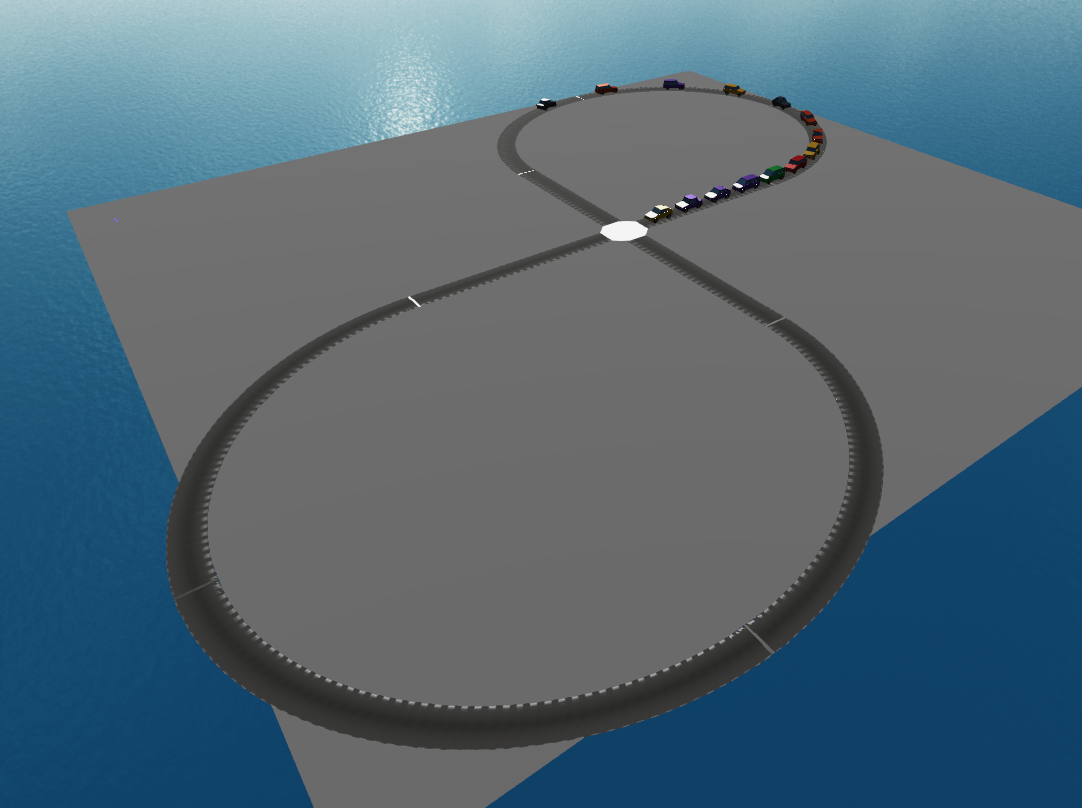

## Training the agent

First we import Ray and RLLib and Flow. There are several benchmarks available, for simplicity we choose *figure 8* here.

In [ ]:
import json

import ray
# We are using Augmented Random Search (ARS) for the optimization of the policy
import ray.rllib.agents.ars as ars
from ray.tune import run_experiments, grid_search
from ray.tune.registry import register_env

from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder

# use this to specify the environment to run
from flow.benchmarks.figureeight0 import flow_params

Next, we set the degree of parallelism. In this case the node has 40 cores, so we use 36 of them for the rollouts (leaving 4 cores to Ray).

In [ ]:
# number of rollouts per training iteration
N_ROLLOUTS = 36
# number of parallel workers
PARALLEL_ROLLOUTS = 36

Next, we create the Flow simulation environment, initialize Ray and set some hyperparameters for the training. Feel free to try out different settings for these parameters and see if the training still works.

In [ ]:
# get the env name and a creator for the environment
create_env, env_name = make_create_env(params=flow_params, version=0)

# initialize a ray instance
ray.init(num_cpus=PARALLEL_ROLLOUTS+1)

config = ars.DEFAULT_CONFIG.copy()
config["num_workers"] = PARALLEL_ROLLOUTS
config["num_deltas"] = N_ROLLOUTS
config["deltas_used"] = N_ROLLOUTS
config["stepsize"] = .01
config["noise_stdev"] = .01
config['policy_type'] = 'LinearPolicy'
config['eval_prob'] = 0.05

# save the flow params for replay
flow_json = json.dumps(flow_params, cls=FlowParamsEncoder, sort_keys=True,
                       indent=4)
config['env_config']['flow_params'] = flow_json

The next lines register the Flow simulation environment with Ray Tune and start the experiment. The default number of training iterations should lead to a reasonable policy, but it is instructional to try different values here.

In [ ]:
# Register as rllib env
register_env(env_name, create_env)

trials = run_experiments({
    flow_params["exp_tag"]: {
        "run": "ARS",
        "env": env_name,
        "config": {
            **config
        },
        "checkpoint_freq": 5,
        "max_failures": 999,
        "stop": {"training_iteration": 25},
    },
})

## Visualizing the policy

The following cell will start the sumo visualization. Wait until "start sumo visualization" is printed and then the policy can be visualized in the webbrowser. Don't worry if you don't understand this code, it sets up a webserver and serves the policy you just trained.

As a reference: This is how the untrained policy would look like: https://www.dropbox.com/s/nvtufthbqjyyd0x/figure_eight-trim.mp4?dl=0

In [ ]:
import subprocess
import psutil
import time
p1 = subprocess.Popen(["python", "flow/flow/visualize/visualizer_rllib.py", trials[0].logdir, "25", "--run", "ARS", "--num_rollouts", "10000000"], stderr=subprocess.PIPE)
# Wait until the visualization is ready
sumo_processes = []
while len(sumo_processes) != 3:
    sumo_processes = [p for p in psutil.process_iter() if p.name() == "sumo"]
    time.sleep(1.0)  
sumo_process, = [p for p in sumo_processes if p.cmdline()[6] == "2"]
port = sumo_process.cmdline()[4]
cfg_path = sumo_process.cmdline()[2]
print("starting sumo visualization")
p2 = subprocess.Popen(["python", "sumo-web3d/sumo_web3d/sumo_web3d.py", "--sumo-port", port, "-c", cfg_path])

## Restarting the Exercise
If the Notebook got into a bad state or you want to restart the exercise with different parameters, run the following:

In [ ]:
import subprocess
subprocess.Popen(["killall", "sumo"])
subprocess.Popen(["killall", "python"])